# RK-PR

The EOS can be given as 

$$ \alpha^{\rm r} = \psi^{(-)} - \dfrac{a_m}{RT } \psi^{(+)} $$

$$ \psi^{(-)} =-\ln(1-b_m\rho ) $$

$$ \psi^{(+)} = \dfrac{\ln\left(\dfrac{\Delta_1 b_m\rho+1}{\Delta_2b_m\rho+1}\right)}{b_m(\Delta_1-\Delta_2)} $$

with the EOS fixed constants of
$$
\Delta_1 = \sum_i x_i \delta_{1,i}
$$
$$
\Delta_2 = \frac{1-\Delta_1}{1+\Delta_1}
$$

The attractive term goes like
$$
a_{i} = a_{c,i}\left(\frac{2}{3+T/T_{c,i}}\right)^{k_i}
$$
with quadratic mixing rules
$$
a_m = \sum_i\sum_jx_ix_j(1-k_{ij})\sqrt{a_{i}(T)a_{j}(T)}
$$
And the covolume also gets quadratic mixing rules
$$
b_m = \sum_i\sum_jx_ix_j(1-l_{ij})(b_{i}+b_{j})/2
$$

Thus, to implement the RK-PR model in predictive mode, the following steps are required:

1. Obtain the critical parameters Tc, pc
2. Solve for delta_1 from the experimental critical compressibility factor, begin with the values from the correlation
3. Solve for k by fixing the pressure at the T=0.7*Tc. In the case (e.g, CO$_2$) that Tt < 0.7*Tc, use instead Tr=Tt/Tc 

It may be necessary to adjust the values of $\delta_{1,i}$ and $k_i$ for an individual component to better match the behavior of more polar components.

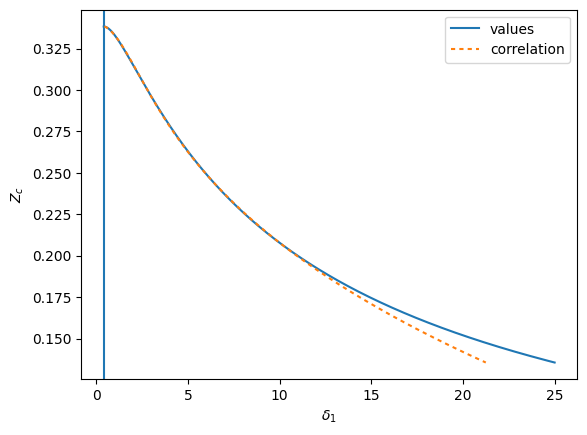

In [1]:
import numpy as np 
import scipy.optimize 
import matplotlib.pyplot as plt 
import teqp, numpy as np
import CoolProp.CoolProp as CP 
import pandas

def delta1_correlation(Zc):
    # Eq. B.4 of Cismondi FPE 2005
    d1 = 0.428363
    d2 = 18.496215
    d3 = 0.338426
    d4 = 0.660000
    d5 = 789.723105
    d6 = 2.512392
    return d1 + d2*(d3-Zc)**d4 + d5*(d3-Zc)**d6 

def Zc_delta1(delta1):
    # Eqs. B.1 to B.3 of Cismondi FPE 2005
    d1 = (1+delta1**2)/(1+delta1)
    y = 1 + (2*(1+delta1))**(1/3) + (4/(1+delta1))**(1/3)
    return y/(3*y + d1 - 1)

DELTA1 = np.linspace(np.sqrt(2)-1, 25, 1000)
ZZ = Zc_delta1(DELTA1)
plt.plot(DELTA1, ZZ, label='values')
DELTA1back = delta1_correlation(ZZ)
plt.axvline(np.sqrt(2)-1)
plt.plot(DELTA1back, ZZ, dashes=[2,2], label='correlation')
plt.gca().set(ylabel='$Z_c$', xlabel='$\delta_1$')
plt.legend(loc='best')
plt.show()

# for Zc in np.linspace(0.2, 0.3383, 1000):
#     resid = lambda x: Zc_delta1(x)-Zc
#     # print(resid(delta1_correlation(Zc)))
#     print(Zc, scipy.optimize.newton(resid, delta1_correlation(Zc)), delta1_correlation(Zc))

In [2]:
names = ['CO2', 'n-Decane']

R = 8.31446261815324
Tc  = np.array([CP.PropsSI(k,"Tcrit") for k in names])
pc  = np.array([CP.PropsSI(k,"pcrit") for k in names])
rhoc = np.array([CP.PropsSI(k,"rhomolar_critical") for k in names])
Zcexp = pc/(rhoc*R*Tc)

# Use a rescaled Zc to obtain delta_1
Zc = 1.168*Zcexp

delta_1 = [scipy.optimize.newton(lambda x: Zc_delta1(x)-Zc_, delta1_correlation(Zc_)) for Zc_ in Zc]

def solve_for_k(i, p_target, Tr):
    """ 
    The value of k for the i-th component is based on getting 
    the right vapor pressure, so a rootfinding routing is
    used to obtain these values
    """
    def objective(k):
        j = {
            "kind": "RKPRCismondi2005",
            "model": {
                "delta_1": [delta_1[i]],
                "Tcrit / K": [Tc[i]],
                "pcrit / Pa": [pc[i]],
                "k": [k],
                "kmat": [[0.0]],
                "lmat": [[0.0]],
            }
        }
        model = teqp.make_model(j)
        T = Tr*Tc[i]
        z = np.array([1.0])
        a, b = model.get_ab(T, z)

        anc = teqp.build_ancillaries(model, Tc[i], rhoc[i], 150)
        rhoL, rhoV = model.pure_VLE_T(T, anc.rhoL(T), anc.rhoV(T), 10)
        p = T*R*rhoL*(1+model.get_Ar01(T, rhoL, z))
        
        return p-p_target
    return scipy.optimize.newton(objective, 2.1)

Tr = 0.7
i = 1
k_C10 = solve_for_k(i, CP.PropsSI('P','T',Tr*Tc[i],'Q',0,names[i]), Tr)

model = teqp.make_model({
    "kind": "RKPRCismondi2005",
    "model": {
        "delta_1": delta_1,
        "Tcrit / K": Tc.tolist(),
        "pcrit / Pa": pc.tolist(),
        "k": [2.23854, k_C10],
        "kmat": [[0,0],[0,0]],
        "lmat": [[0,0],[0,0]],
    }
})

# Start at both pures
for ipure in [0, 1]:
    Tc, rhoc = model.solve_pure_critical(300, 5000, {"alternative_pure_index":ipure, "alternative_length": 2})
    z = np.array([0.0, 0.0]); z[ipure] = 1.0
    pc = Tc*R*rhoc*(1+model.get_Ar01(Tc, rhoc, z))
    plt.plot(Tc, pc/1e5, 'o')
    
    opt = teqp.TCABOptions(); opt.polish=True; opt.verbosity=100; opt.integration_order=5; opt.rel_err=1e-10; opt.abs_err=1e-10
    trace = model.trace_critical_arclength_binary(Tc, z*rhoc, options=opt)
    df = pandas.DataFrame(trace)
    plt.plot(df['T / K'], df['p / Pa']/1e5)
    
# Overlay the data from Reamer and Sage, Cismondi additional data points not present in Reamer and Sage
Tc_K = [310.928, 344.261, 377.594, 410.928, 444.261, 477.594, 510.928]
pc_kPa = np.array([7997.92, 12824.25, 16492.26, 18560.69, 18836.48, 17836.74, 15333.94])
plt.plot(Tc_K, pc_kPa/1e2, 'o')

plt.gca().set(xlabel='$T$ / K', ylabel='$p$ / bar');

ValueError: Don't understand "kind" of: RKPRCismondi2005